# Detecting spam messages
This project will use keras and nltk to classify whether text messages are spam or not

Steps:
* Preprocess and clean data
* conduct data visualisation and EDA
* build the model
* train/test
* optimise
* evaluate metrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

2023-07-19 10:28:38.598091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df=pd.read_csv('spam.csv',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Preprocessing
* Clean data by dropping empty columns
* Rename columns appropriately
* Perform one-hot-encoding on labels

In [3]:
#drop missing data
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
#rename columns
df.rename(columns={'v1':'label','v2':'text'},inplace=True)
#one hot encoding on labels
df['label_enc']=df['label'].map({'ham':0,'spam':1})

## EDA and visualisation
* Compare the numbers of spam and ham messages
* Look for key characteristics that might indicate label
* Make statistical inferences from the data set

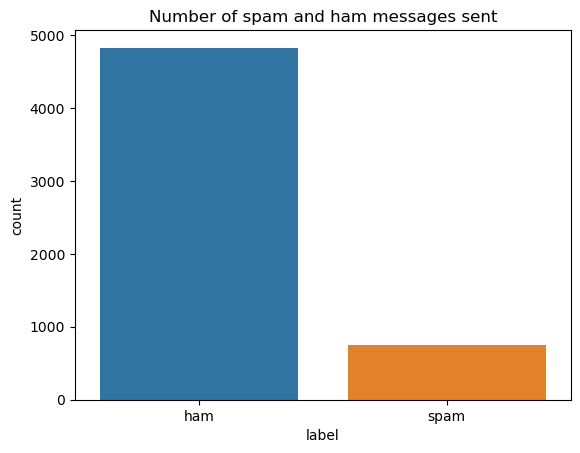

In [4]:
sns.countplot(x=df['label'])
plt.title('Number of spam and ham messages sent')
plt.show()

There are significantly more ham messages than spam messages. Now we analyse the content of the messages instead. No balancing of data is required to account for bias since the model will use embedding.

In [5]:
avg_text_len=round(sum(len(i.split()) for i in df['text'])/len(df['text']))
print(f'The average length of a text is {avg_text_len} words')
s=set()
for text in df['text']:
    for word in text.split():
        s.add(word)
print(f'{len(s)} unique words have been used in all messages')

The average length of a text is 15 words
15585 unique words have been used in all messages


## Building a model
* create a training/testing set
* build differemt models with layers

### Baseline
* Uses only classical natural language processing methods
* No deep learning methods

In [6]:
#training/testing sets
from sklearn.model_selection import train_test_split
#experimental conditions
RS=42
testing_size=0.2
eps=5
X,y=np.asanyarray(df['text']),np.asanyarray(df['label_enc'])
deploy_df=pd.DataFrame({'text':X,'label':y})
X_train,X_test,y_train,y_test=train_test_split(deploy_df['text'],deploy_df['label'],test_size=testing_size,random_state=RS)

In [7]:
#baseline model for comparison
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report
#instantiate model
tfidf_vec=TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec=tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)
baseline_model=MultinomialNB()
baseline_model.fit(X_train_vec,y_train)
#evaluate
y_pred=baseline_model.predict(X_test_vec)
accuracy=accuracy_score(y_test,y_pred)
print(f'Accuracy of baseline is {accuracy}')
classification_report(y_test,y_pred)

Accuracy of baseline is 0.9623318385650225


'              precision    recall  f1-score   support\n\n           0       0.96      1.00      0.98       965\n           1       1.00      0.72      0.84       150\n\n    accuracy                           0.96      1115\n   macro avg       0.98      0.86      0.91      1115\nweighted avg       0.96      0.96      0.96      1115\n'

[Text(0, 0.5, 'Spam'), Text(0, 1.5, 'Ham')]

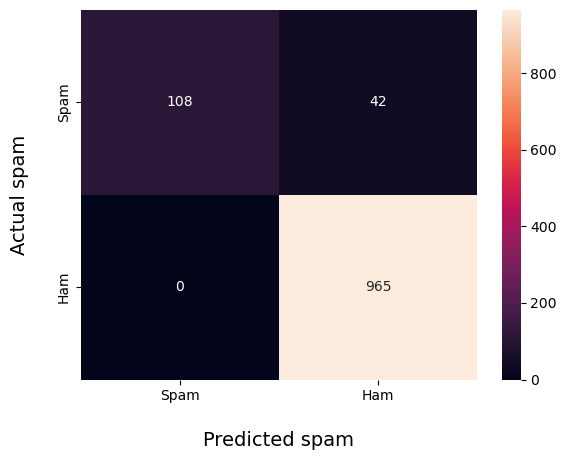

In [8]:
#visualise results using confusion matrix
from sklearn.metrics import confusion_matrix
cnf_mat=confusion_matrix(y_test,y_pred,labels=[1,0])
ax = sns.heatmap(cnf_mat, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted spam", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Spam', 'Ham'])

# set y-axis label and ticks
ax.set_ylabel("Actual spam", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Spam', 'Ham'])

### Custom text vectorisation and embedding
* Converts text to numerical data
* Examples include bag of words, binary term frequency
* Embedding is the process of finding and grouping words that may carry similar sentiments into vectors. Vectors' values are found similar to how a neural network finds its weights.
* Model uses tensorflow

In [9]:
from tensorflow.keras.layers import TextVectorization
#instantiate model
MaxTokens=len(s)
out_len=avg_text_len
text_vec=TextVectorization(max_tokens=MaxTokens,
                          standardize='lower_and_strip_punctuation',
                          output_mode='int',
                          output_sequence_length=out_len)
#fit model
text_vec.adapt(X_train)

2023-07-19 10:28:42.601726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
#create embedding layers
output_dim=120#HYPERPARAMETER
embedding_layer=layers.Embedding(input_dim=MaxTokens,#size of vocab used in texts
                                output_dim=output_dim,#size of vector used during embedding
                                embeddings_initializer='uniform',#sets initial weights of embedding model
                                input_length=out_len#length of input sequences
                                )
input_layer=layers.Input(shape=(1,),dtype=tf.string)
vector_layer=text_vec(input_layer)#fitting
embedding_layer_model=embedding_layer(vector_layer)#fitting
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)
 
model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
    label_smoothing=0.5), metrics=['accuracy'])#sets criteria for model optimisation
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 120)           1870200   
                                                                 
 global_average_pooling1d (G  (None, 120)              0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 120)               0         
                                                                 
 dense (Dense)               (None, 32)                3872  

In [11]:
#train and test model on multiple epochs
training_history=model_1.fit(X_train,y_train,epochs=eps,validation_data=(X_test,y_test),
                            validation_steps=int(0.2*len(X_test)))

Epoch 1/5
140/140 [==============================] - 1s 4ms/step - loss: 0.6094 - accuracy: 0.9026 - val_loss: 0.5767 - val_accuracy: 0.9722
Epoch 2/5
140/140 [==============================] - 0s 4ms/step - loss: 0.5705 - accuracy: 0.9859 - val_loss: 0.5734 - val_accuracy: 0.9803
Epoch 3/5
140/140 [==============================] - 0s 3ms/step - loss: 0.5660 - accuracy: 0.9946 - val_loss: 0.5726 - val_accuracy: 0.9830
Epoch 4/5
140/140 [==============================] - 0s 3ms/step - loss: 0.5643 - accuracy: 0.9978 - val_loss: 0.5726 - val_accuracy: 0.9821
Epoch 5/5
140/140 [==============================] - 0s 3ms/step - loss: 0.5634 - accuracy: 0.9989 - val_loss: 0.5725 - val_accuracy: 0.9830


<AxesSubplot:>

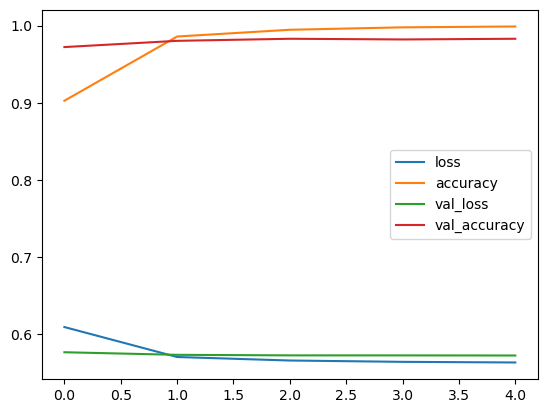

In [12]:
#visualise progress
pd.DataFrame(training_history.history).plot()

### Bidirectional LSTM
* Accepts long and short term memory in two different directions
* improves algorithm's ability to predict preceding words in sentences

In [13]:
#create functions that can assist operations for this model
from sklearn.metrics import precision_score, recall_score, f1_score
 
def compile_model(model):
    '''
    simply compile the model with adam optimzer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
 
def fit_model(model, epochs, X_train=X_train, y_train=y_train,
              X_test=X_test, y_test=y_test):
    '''
    fit the model with given epochs, train
    and test data
    '''
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        validation_steps=int(0.2*len(X_test)))
    return history
 
def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy,
    precision, recall and f1-score
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)
 
    model_results_dict = {'accuracy': accuracy,
                          'precision': precision,
                          'recall': recall,
                          'f1-score': f1}
 
    return model_results_dict

In [14]:
#model building
input_layer=layers.Input(shape=(1,),dtype=tf.string)
vector_layer=text_vec(input_layer)#fitting
embedding_layer_model=embedding_layer(vector_layer)#fitting
bi_lstm = layers.Bidirectional(layers.LSTM(
    64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
#activation function layer
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)
 
compile_model(model_2)  # compile the model
history_2 = fit_model(model_2, epochs=eps)  # fit the model

Epoch 1/5
140/140 [==============================] - 5s 21ms/step - loss: 0.0612 - accuracy: 0.9794 - val_loss: 0.1133 - val_accuracy: 0.9785
Epoch 2/5
140/140 [==============================] - 2s 16ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0986 - val_accuracy: 0.9830
Epoch 3/5
140/140 [==============================] - 2s 16ms/step - loss: 5.6131e-04 - accuracy: 0.9998 - val_loss: 0.1127 - val_accuracy: 0.9848
Epoch 4/5
140/140 [==============================] - 2s 16ms/step - loss: 3.7353e-05 - accuracy: 1.0000 - val_loss: 0.1249 - val_accuracy: 0.9848
Epoch 5/5
140/140 [==============================] - 2s 16ms/step - loss: 1.5453e-05 - accuracy: 1.0000 - val_loss: 0.1324 - val_accuracy: 0.9839


<AxesSubplot:>

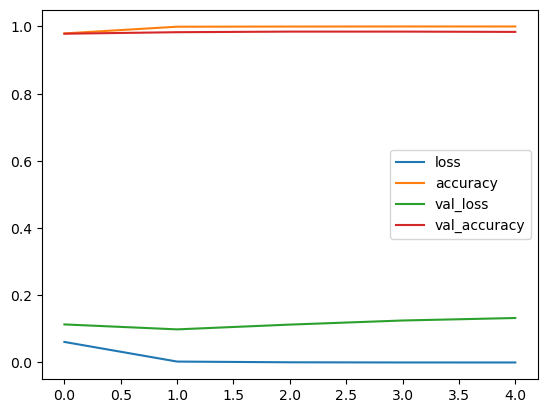

In [15]:
pd.DataFrame(history_2.history).plot()

### Transfer learning
* A model that is specially designed for one task is used a foundation for a model that performs another task
* This model has USE (Universal sentence encoder) layers that convert text to higher dimensional vectors which can be used for text categorisation, sentiment analysis and other techniques.

In [16]:
import tensorflow_hub as hub
model_3=keras.Sequential()
#create universal sentence encoding layer
use_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                        trainable=False,
                        input_shape=[],
                        dtype=tf.string,
                        name='USE')
#add activation layers
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))

In [17]:
compile_model(model_3)
history_3=fit_model(model_3,epochs=eps)

Epoch 1/5
140/140 [==============================] - 2s 8ms/step - loss: 0.2944 - accuracy: 0.9152 - val_loss: 0.1144 - val_accuracy: 0.9704
Epoch 2/5
140/140 [==============================] - 1s 5ms/step - loss: 0.0808 - accuracy: 0.9791 - val_loss: 0.0711 - val_accuracy: 0.9776
Epoch 3/5
140/140 [==============================] - 1s 5ms/step - loss: 0.0554 - accuracy: 0.9845 - val_loss: 0.0604 - val_accuracy: 0.9803
Epoch 4/5
140/140 [==============================] - 1s 5ms/step - loss: 0.0490 - accuracy: 0.9863 - val_loss: 0.0540 - val_accuracy: 0.9812
Epoch 5/5
140/140 [==============================] - 1s 5ms/step - loss: 0.0416 - accuracy: 0.9865 - val_loss: 0.0535 - val_accuracy: 0.9812


## Comparing models
* When making an analysis, the suitability of metrics used across all comparisons must be considered.
* Additionally, the time complexity and limitations must be considered

In [18]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)
 
total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
                             'Custom-Vec-Embedding Model':model_1_results,
                             'Bidirectional-LSTM Model':model_2_results,
                             'USE-Transfer learning Model':model_3_results}).transpose()
 
total_results

35/35 [==============================] - 0s 4ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.983857,0.985294,0.893333,0.937063
Bidirectional-LSTM Model,0.983857,0.985294,0.893333,0.937063
USE-Transfer learning Model,0.981166,0.970803,0.886667,0.926829


### Comments:
* All models performed reasonably well with regards to accuracy making it an unsuitable choice to compare against for all models.
* Similarly, precision amongst the embedding, LSTM and USE models were extremely similar
* Recall seems to be an ideal candidate to distinguish performance amongst the models however as f1 score quantifies overall precision and recall by definition, it is indeed a more appropriate measure despite the lack of distinction between models.
* Based on prior deductions of the appropriate measures to use, it is clear that the Universal Sentence Encoder performed best, judging by the comparatively higher f1 score and simiarly high accuracy.
* To get a better grasp of the comparison between the performances of these models, a visualisation is provided for each model

<AxesSubplot:>

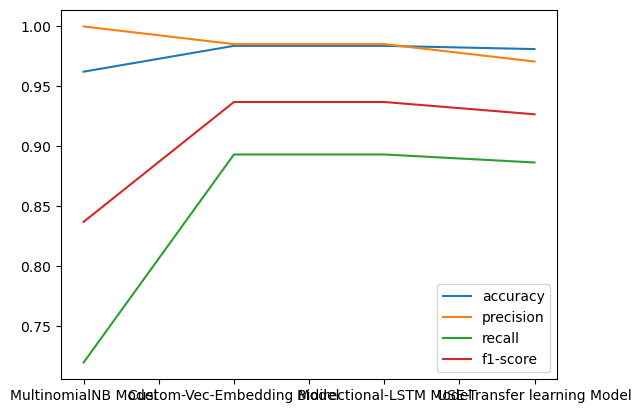

In [19]:
total_results.plot()